<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias_ngrams_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster, single, complete, average
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [3]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 3 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [4]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [5]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [6]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(28122, 3)


In [7]:
dfDados = dfDados.sample(frac=0.50, random_state=123)
print(dfDados.shape)

(14061, 3)


In [10]:
dfDados.columns

Index(['text', 'category', 'category_nro'], dtype='object')

62


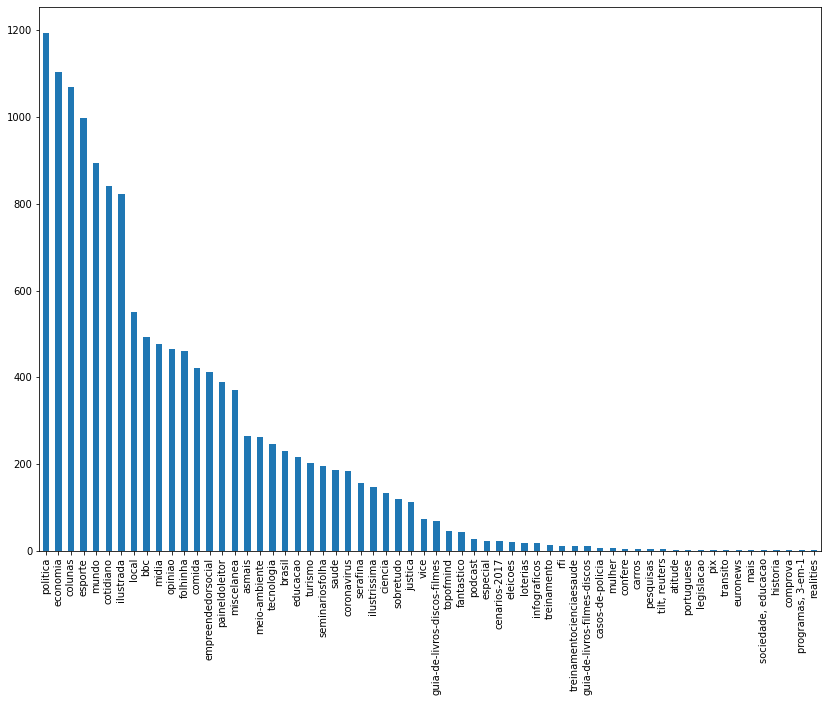

In [17]:
df = dfDados['category'].value_counts()
print(dfDados['category'].unique().size)
df.plot.bar(figsize=(14,10))


In [18]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 1.37 s, sys: 415 ms, total: 1.78 s
Wall time: 3min 38s


In [19]:
print(dfPreProc.shape)
dfPreProc.head()

(14061, 3)


,text,category,category_nro
20068,paul paix bols torn profiss médic gabriel mach jornal raíss mach cunh cinc ano sóc bols loj onlin comercializ maior model r empresár invest r abr empr fatur r milhã cresc form mod am assunt sempr busc refer viag internet blog red soc ach bols desej diz jornal coleç ver lanç prim it mão obr artesan bols croch cheg loj nest seman próx pass vend peç atac oper começ fever sequ empresár planej lev bols argentin,sobretudo,17
18920,supervi compreend sab marcy shermanlewil funcionár serviç atend client falt algum dia pal mor hor dal mal alzheim mãe consult médic pai viv cim baix estr diss marcy filh únic acab férias licenç médic folg entant chef recus dar temp adic long empreg sab quer temp escritóri pergunt qual plan vai faz colocál cas repous plan marcy demit marid engenh aposent pud mud overland park kans eua cidad pal st joseph missour sab pod ach empreg ach começ funcion perfeit porém mal alzheim avanç direç marcy receb ligaç escritóri pal mistur remédi pai cad vez descontrol mãe pass mão fogã queim braç queimad grav apavor diss marcy filh deix empreg nov possi sempr emb pal morr marid ano receb diagnóst alzheim ano exig atenç temp integr ano recémcomplet lament decis pergunt dia volt trabalh licençafamíl remuner agor obrigatór trê est eua prova apreci vár assemble legisl ano vem pod ter ampli carr brasil serv públic possu benefíci licenç motiv doenç pesso famíl próx prim mê venc sofr cort geral reduç progress salári cheg licenç remuner pod ser acompanh oa cônjug companheiro pal filh ente padrast madrast depend atest necess períc médic trabalh set priv aind benefic previs legal ness sent tramit câm sen projet busc equipar celet serv públic necessár licenç dev ser negoci licenç estimas cerc milh americ cuid alguém ano maior empreg segund estud recent respeit trabalh precis faz malabar particul complic cuid filh felic cont filh saud tornas razoa previs long temp tir inevit infecç ouv doenç passag cuid idos entant exig reviravolt mud vid avis qued incapacit acid vascul grav necess assist pesso idos costum aument funç vid long trabalh cuid temp pal form intens cas filh além diss impact emoc difer segund kenneth mat dire pesquis famili and work institut cri crianç pass event feliz mai independ cuid idos pass experi trist legisl lei feder trat licenç médic famili ajud algum cuid trabalh exempl proteg empreg lei limitaç atend soment popul ativ exceç empr menos funcion soment cuid cônjug pai filh inclu parent afin avó clar remuner nov york lei aprov assemble legisl prev seman licenç pag ano trabalh mei períod integr cuid recémnasc crianç recémadot famili problem saúd grav govern andrew m cuom compromet sancionál organizaç empresar levant objeç emb estud lei californi prev seil seman licenç constat efeit mín sobr empreg outr est inclu connecticut dev avali legisl simil ano vem conjunt capit americ parlamant democrat apresent recent projet lei fic conhec lei famíl perd rend trabalh cuid adult ano metad inform algum influ deletér serviç inform associ aposent nation allianc caregiving dess pesso falt formal reduz hor encontr empreg menos exig aposent ant planej deix trabalh fic parent consequ financ perd rend atual futur pod revel espec problemá mulh méd ganh menos comu cuid sustent use tod poupanç aposentad diss marcy shermanlewil após ano desempreg enfrent reduç benefíci previd soc licenç remuner vai resolv tod dilem cuid clar talv funcion melhor dur mes ano ajud pal recuper cirurg quadril transportál consult colabor faz compr cozinh pai maryann manelsk vez fic cad vez incapacit parkinson precis tom remédi vár vez dia diss cineast novaiorquin ano precis troc lençol tod dia assim dur ano defend projet lei nov york seman licenç remuner anual salv tod ano pass cuid porém talv cineast pod trabalh temp,saude,13
3618,rio jan cômic trág atual situ polít sac gat tod mi enquant país parec naufrag mar corrupç gener exceç gross man depend falcatru dela delat acus si temp naçã mergulh città dolent dant coloc port infe

In [ ]:
#dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv',index=False)
#dfPreProc = pd.read_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')
#dfPreProc['text'] = dfPreProc['text'].astype('unicode')

In [20]:
V = processaVetorizacao(dfPreProc,min_fr=0.1, max_fr=0.8, ngrams=(1,2))
X_tfidf = retornaMatriztfIdf(V)

In [21]:
%%time
#https://www.kaggle.com/tchainzzz/agglomerative-document-clustering-on-cord-19

dist = 1 - cosine_similarity(X_tfidf)
dist = dist - dist.min()
linkage_matrix = average(dist) #ward(dist)

CPU times: user 25min 4s, sys: 3.18 s, total: 25min 8s
Wall time: 24min 58s


* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


In [ ]:
#X = np.ones((X_tfidf.shape))
#X_tfidf.toarray(out=X)


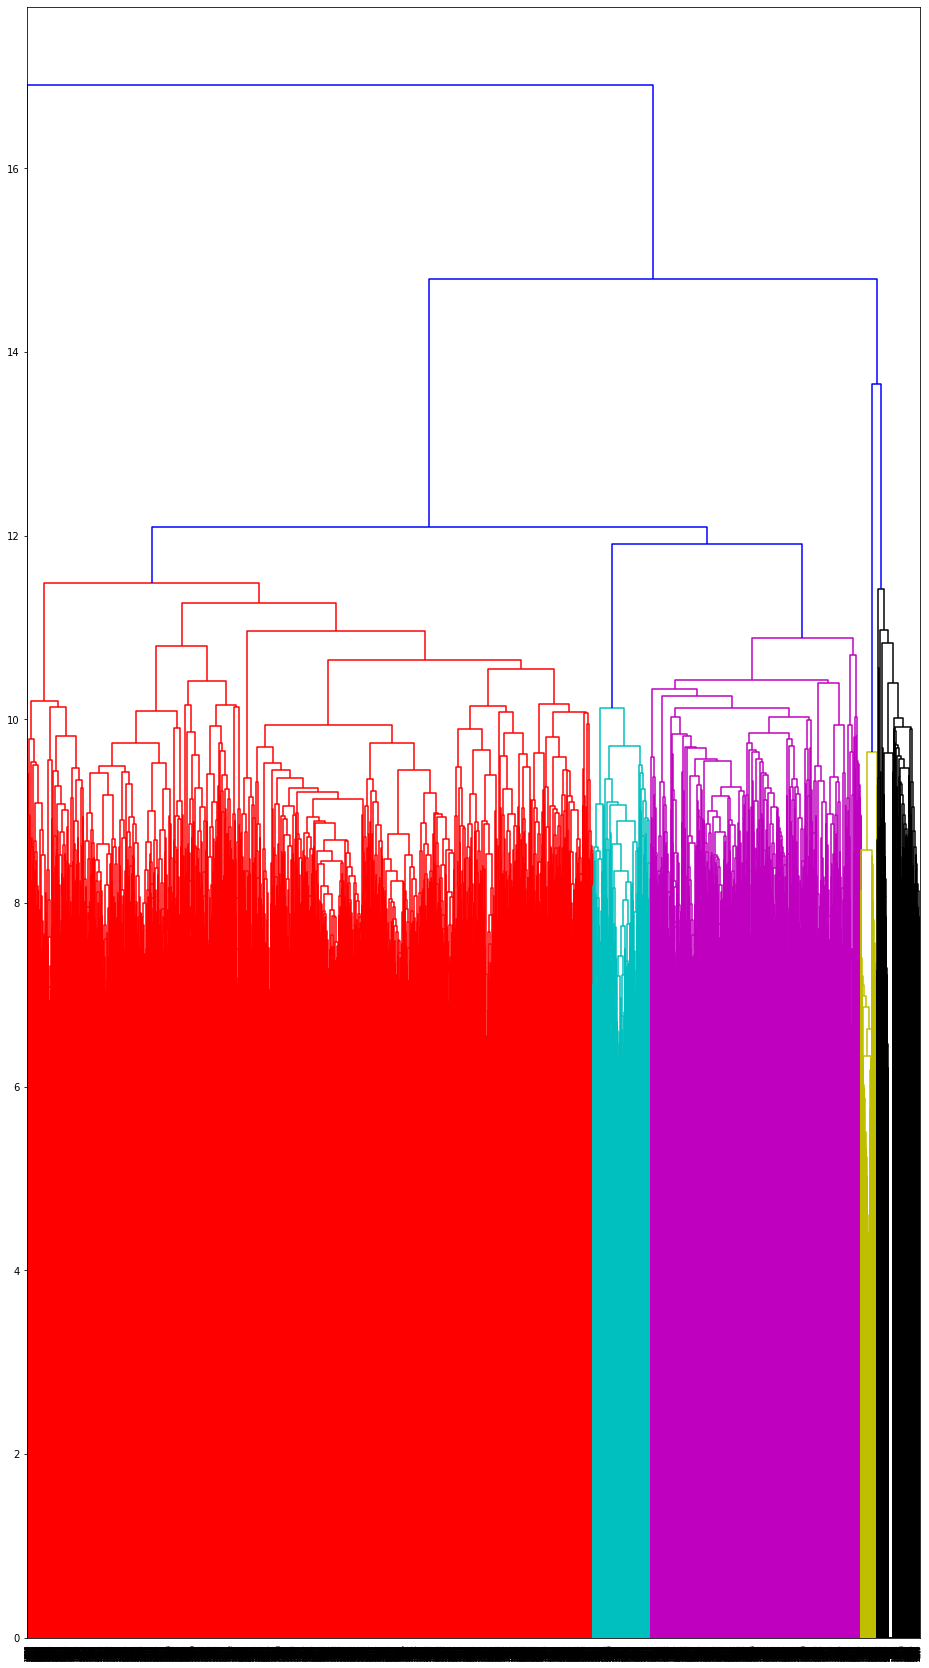

CPU times: user 5min 57s, sys: 33.2 s, total: 6min 30s
Wall time: 6min 17s


In [22]:
%%time
plt.figure(figsize=(16, 30))
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

Similaridade Coseno

In [23]:
X_cosine = X_tfidf.toarray()
print(np.where(~X_cosine.any(axis=1))[0])
z = np.where(~X_cosine.any(axis=1))[0]
for i in z:
  X_cosine[i] = np.ones(X_cosine[i].shape)*1/100
print(np.where(~X_cosine.any(axis=1))[0])

[   38   122   303   712   734  1017  1037  1072  1243  1330  1519  1864
  2098  2390  2676  3143  3702  3817  3843  4121  4161  4240  4282  4332
  4345  4390  4659  4952  5050  5146  5408  5555  5788  5840  5908  6080
  6154  6518  6529  6647  6901  6958  7012  7067  7121  7424  7470  7532
  7662  7701  7853  7897  8037  8242  8501  8573  8873  8884  9165  9240
  9855 10096 10323 10728 10821 11072 11248 11389 11403 11604 11762 11833
 11882 12077 12339 12752 12850 12962 13274 13400 13513 13842]
[]


Para 8 clusters

In [28]:
#model= AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average')
#dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)
model= AgglomerativeClustering(n_clusters=8, affinity='cosine', linkage='average')
y_pred = model.fit_predict(dist)

<BarContainer object of 8 artists>

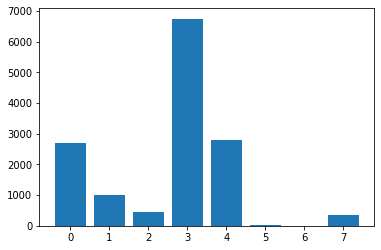

In [29]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


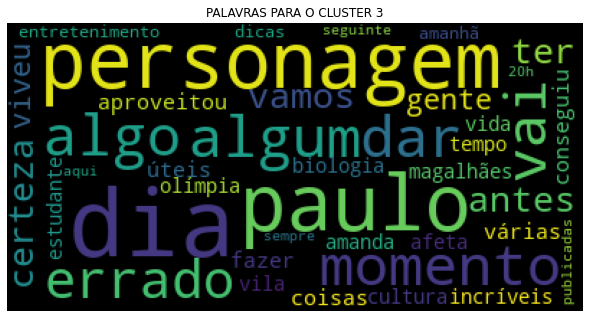

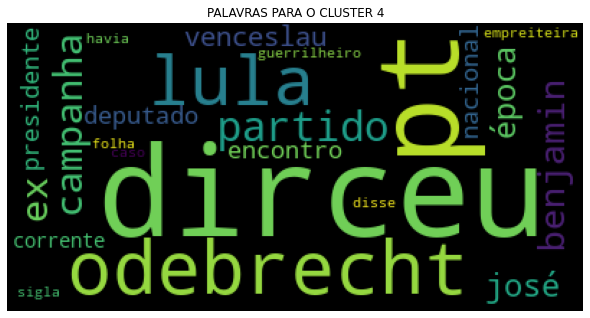

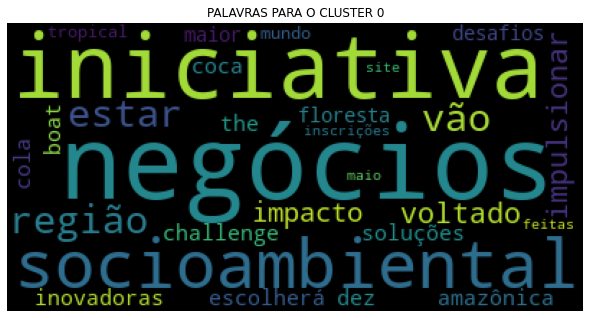

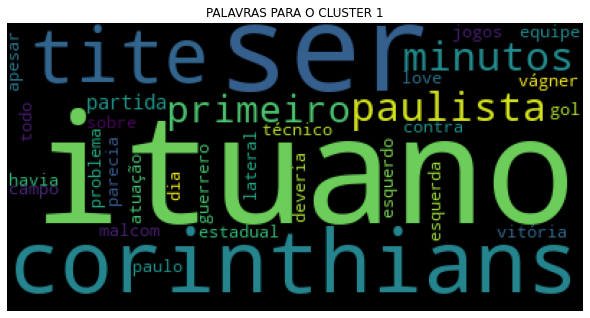

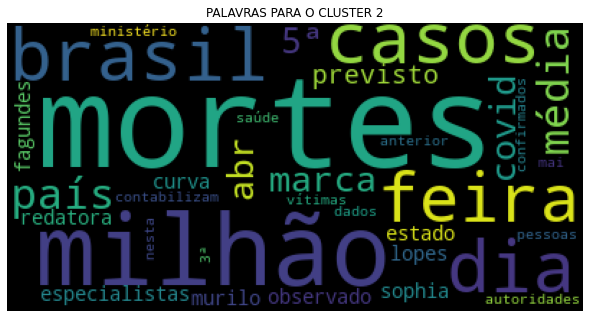

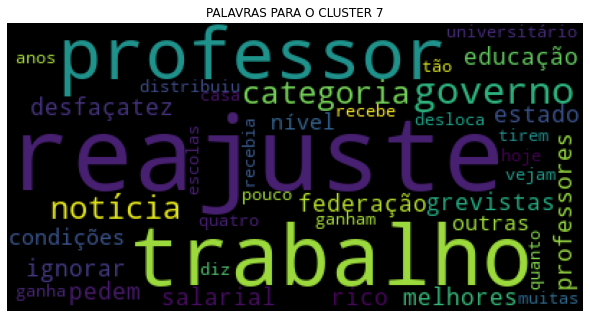

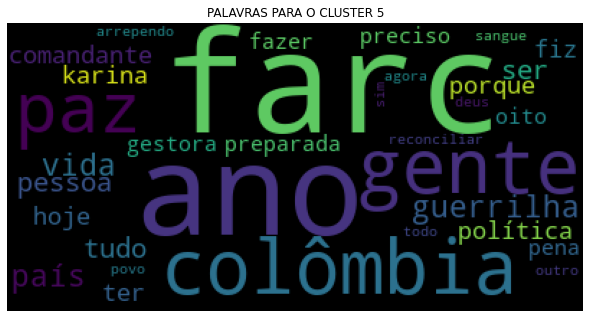

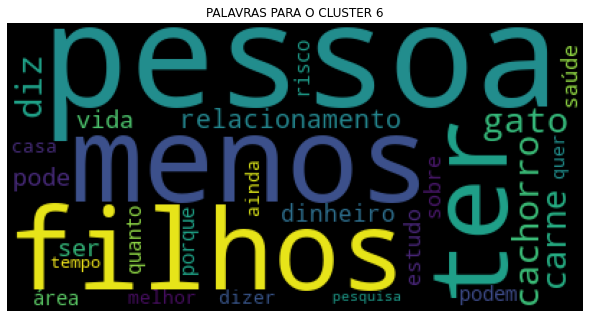

In [31]:
#dfconta = dfDados['y_pred'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['y_pred'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

Para 12 Clusters

In [ ]:
model= AgglomerativeClustering(n_clusters=16, affinity='cosine', linkage='average')
y_pred = model.fit_predict(dist)

In [ ]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


In [ ]:
#dfconta = dfDados['y_pred'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['y_pred'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

In [ ]:
dfDados[dfDados['y_pred']==1][['category','y_pred']].groupby('category').count().reset_index().rename(columns={'y_pred':'qtd'}).sort_values(by='qtd', ascending=False)

,category,qtd
7,economia,15
21,politica,11
3,colunas,10
6,cotidiano,10
19,mundo,8
9,esporte,8
20,opiniao,6
18,miscelanea,4
16,meio-ambiente,4
1,bbc,4


In [ ]:
dfDados[dfDados['y_pred']==4].sample(10)

,text,category,category_nro,y_pred
17781,"CHROMATIK Android, iOS e Web ONDE chromatik.com QUANTO Gratuito Agora no Android, o Chromatik é uma ótima solução gratuita para músicos que querem aprender a tocar as canções de seus artistas prediletos, sejam clássicos ou contemporâneos. Não é um acervo ... Leia post completo no blog",tecnologia,11,4
10824,"Pessoas que passaram pela região da Vila Madalena, zona oeste de São Paulo, na tarde desta sexta-feira (27), se surpreenderam com um carro tombado na rua Rodésia. O veículo tombou após se envolver em um acidente com outro carro, no início da tarde. Ninguém ficou ferido, mas o veículo continuava no local da batida por volta das 15h.",cotidiano,5,4
10628,"JOÃO PEDRO PITOMBO DE SALVADOR A apreensão de latinhas de cervejas de marcas que não patrocinam o Carnaval de Salvador triplicou e chegou a 1,2 milhão de unidades. Em vigor desde 2014, o sistema de exclusividade -baseado no modelo usado ... Leia post completo no blog",cotidiano,5,4
1048,"Ministro Dias Toffoli nega seguimento a mandado de segurança da União contra pagamento do benefício. O ""Diário da Justiça"" publica decisão monocrática do ministro Dias Toffoli, do Supremo Tribunal Federal, que negou seguimento a mandado de segurança impetrado pela ... Leia post completo no blog",politica,0,4
21382,"Engana-se quem pensa que Carnaval de rua é apenas coisa para adulto. A partir deste fim de semana, uma série de blocos para crianças tomam as ruas de São Paulo e do Rio. Para curtir a data com as crianças, confira abaixo oito opções de blocos, quatro em cada cidade. * SÃO PAULO Mamãe Eu Quero O bloco Mamãe Eu Quero incentiva crianças e famílias a deixarem o preconceito de lado e se fantasiarem da forma como quiserem. Crianças ritmistas da Bateria Encantada tocam fantasiados de ninjas, princesas, super-heróis e outros personagens infantis. ONDE pça. Irmãos Karmann, Perdizes QUANDO dia 30/1, às 9h - Os Fraldinhas e Alfinetes Em sua primeira edição, o bloco Os Fraldinhas e Alfinetes leva as crianças e pais para uma volta pelo bairro de Moema. Organizada por uma loja de papinhas, a festa terá distribuição de fantasias e adereços. QUANDO dia 30/1, às 10h ONDE av. Jandira 781, Moema - Emílias e Viscondes Criado em 2006, o Bloco das Emílias e Viscondes é inspirado na obra de Monteiro Lobato, por isso as crianças se fantasiam de personagens do Sítio do Picapau Amarelo. Neste ano, Mário de Andrade será homenageado pelo cortejo. QUANDO 2, 3 e 4/2, às 15h; e dia 5/2, às 14h ONDE Biblioteca Monteiro Lobato - rua General Jardim, 485, Vila Buarque - Banda do Bloquinho O bloco da Banda do Bloquinho traz um repertório que inclui músicas infantis, MPB e rock, além das tradicionais marchinhas. Com o tema ""brincar"", o bloco convida crianças e pais a brincarem, deixando de lado as preocupações do dia a dia. QUANDO dia 13/2, às 9h ONDE pça. Horácio Sabino, Vila Madalena * RIO DE JANEIRO Mini Bloco O Mini Bloco é organizado por um grupo de pais. Neste ano, ele vai recolher doações de materiais artísticos para crianças com câncer, em parceria com a Casa Ronald McDonald do Rio de Janeiro. A música também fica por conta dos pequenos. QUANDO dia 30/1, às 9h ONDE pça. Xavier de Brito, Tijuca - Bloco Boi Dormir Inspirado nos carnavais folclóricos, o Bloco Boi Dormir leva ao público histórias, música, samba e cultura popular. As festividades ficam por conta da companhia teatral ""Histórias pra Boi Dormir"", que ao longo do ano visita escolas públicas levando contação de histórias e apresentações de teatro. QUANDO dia 31/1, às 16h ONDE rua Dias da Cruz, 100, Meier - Gigantes da Lira Primeiro bloco infantil do Rio, o Gigantes da Lira foi criado em 1999 e traz como símbolo o boneco gigante do Bobo da Corte. Diversos outros personagens integram o cortejo, como Luiza, a Princesa e o palhaço Dr. Giramundo da Lira e Psiu. QUANDO dia 31/1, às 9h ONDE rua General Glicério, Laranjeiras - Bandinha de Ipanema O bloco é a versão infantil do tradicional Banda de Ipanema. No Ba